In [1]:
import os
import glob
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.set_option('display.max_columns', None)

**Log historical condor job classads every 6 hours with a script like**
```bash
#!/usr/bin/env sh
mkdir -p logs
attributes="ClusterId,ProcId,ExitStatus,JobStatus,LastJobStatus,MATCH_EXP_JOB_GLIDEIN_SiteWMS_Slot,MATCH_GLIDEIN_Site,JobRunCount,RequestMemory,JobStartDate,MATCH_EXP_JOBGLIDEIN_ResourceName,User,Owner,ResidentSetSize_RAW,CumulativeRemoteUserCpu,BytesRecvd,RemoteWallClockTime,NumJobStarts,BytesSent,ExecutableSize_RAW,CumulativeSlotTime,ExitCode,CompletionDate,TransferInputSizeMB,RemoteUserCpu,RequestDisk,RequestCpus,DiskUsage_RAW"
timestamp=$(date +%F_%T_%s | sed -s 's/[-:]//g')
for uafnum in 4 8 10; do
    fname="logs/history_uaf${uafnum}_${timestamp}.txt.gz"
    echo "Writing to $fname"
    earlier=$(($(date +%s) - 6*3600)) # 6 hours
    condor_history -name uaf-${uafnum}.t2.ucsd.edu -since "CompletionDate<${earlier}"  -json -attributes  ${attributes} | gzip -9 > $fname
done
```

In [55]:
def get_condor_df():
    """
    Each gzipped file is just a list of jsons for job classads
    which were taken from condor_history every 6 hours.
    Cache the output in a pickle file
    """
    pkl_fname = "data/df_condor.pkl.bz2"
    if os.path.exists(pkl_fname):
        return pd.read_pickle(pkl_fname)
    fnames = glob.glob("data/condor/logs/*.gz")
    dfs = []
    for fname in tqdm(fnames):
        try: df = pd.read_json(fname)
        except: continue
        dfs.append(df)
    df = pd.concat(dfs).reset_index()
    k = [
        "LastJobStatus","ExitCode","ExitStatus","JobStatus",
        "Owner","User","MATCH_GLIDEIN_Site",
        "MATCH_EXP_JOB_GLIDEIN_SiteWMS_Slot","User",
    ]
    df[k] = df[k].astype("category")
    k = ["JobRunCount","NumJobStarts"]
    df[k] = df[k].fillna(0).astype("uint16")
    df = df.drop(["BytesRecvd","BytesSent","ExecutableSize_RAW"],axis=1)
    df.to_pickle(pkl_fname)
    return df

**Log hadoop metrics every 6 hours with a script like**
```bash
#!/usr/bin/env sh
mkdir -p logs
fname="logs/nodes_$(date +%F_%T_%s | sed -s 's/[-:]//g').txt"
echo "Writing to $fname"
echo "Getting hadoop info"
hdfs fsck -locations -blocks -files /cms/store/group/snt/run2_data2018/MET_Run2018D-PromptReco-v2_MINIAOD_CMS4_V10-02-04/ > $fname
echo "Parsing hadoop info to get unique node IPs"
ips=$(grep -oE '[0-9]{2,3}\.[0-9]{2,3}\.[0-9]{2,3}\.[0-9]{2,3}:' ${fname} | cut -d ':' -f1 | sort | uniq)
echo "Found $(echo $ips | wc -w) unique node IPs"
echo >> $fname
echo "-------- BEGIN DNS LOOKUP --------" >> $fname
for ip in ${ips} ; do h=$(host -W 1 $ip); echo $ip $h ; done >> $fname
echo "-------- END DNS LOOKUP --------" >> $fname
```

In [56]:
def get_hadoop_df(skip_cache=False):
    """
    Each text file has the output of hadoop fsck as well as a DNS/hostname lookup on the node IPs.
    Cache the output in a pickle file.
    """
    pkl_fname = "data/df_hadoop.pkl"
    if os.path.exists(pkl_fname) and not skip_cache:
        return pd.read_pickle(pkl_fname)
#     fnames = glob.glob("data/hadoop/logs/*.txt")
    fnames = glob.glob("data/hadoop/slimmed/*.txt")
    data = []
    # Strip out t2 suffix
    def parse_dns(x):
        return x.split()[-1][:-1].replace(".t2.ucsd.edu","")
    for fname in fnames:
        dnslines = []
        nodes = None
        in_dns = False
        for line in open(fname,"r"):
            if line.startswith(" Number of data-nodes"): nodes = int(line.split()[-1])
            elif line.startswith("-------- BEGIN DNS LOOKUP"): in_dns = True
            elif line.startswith("-------- END DNS LOOKUP"): in_dns = False
            elif in_dns:
                if ("BEGIN" not in line) and ("timed out" not in line):
                    dnslines.append(line)
        hosts = set(map(parse_dns,dnslines))
        timestamp = int(fname.rsplit("_",1)[1].rsplit(".",1)[0])
        data.append(dict(timestamp=timestamp,hosts=hosts,nodes=nodes))
    df = pd.DataFrame(data)
    df = df.sort_values("timestamp",ascending=True).reset_index()
    # Pairwise set subtractions to get hosts that were added or lost
    df["hosts_gained"] = pd.Series([set()]+map(lambda x:x[0]-x[1], zip(df.hosts.values[1:],df.hosts.values[:-1])))
    df["hosts_lost"] = pd.Series([set()]+map(lambda x:x[1]-x[0], zip(df.hosts.values[1:],df.hosts.values[:-1])))
    df["nhosts_gained"] = df.hosts_gained.map(len)
    df["nhosts_lost"] = df.hosts_lost.map(len)
    df["nhosts"] = df.hosts.map(len)
    df["date"] = pd.to_datetime(df["timestamp"],unit="s").dt.tz_localize("UTC").dt.tz_convert("US/Pacific")
    df = df.drop(["hosts","timestamp"],axis=1)
    df.to_pickle(pkl_fname)
    return df

In [58]:
df_condor = get_condor_df()

100%|██████████| 1435/1435 [01:20<00:00, 17.82it/s]
/Users/namin/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


In [5]:
df_hadoop = get_hadoop_df()

In [49]:
# Historical job ClassAd information
df_condor.head()

,index,ClusterId,CompletionDate,CumulativeRemoteUserCpu,CumulativeSlotTime,DiskUsage_RAW,ExitCode,ExitStatus,JobRunCount,JobStartDate,JobStatus,LastJobStatus,MATCH_EXP_JOBGLIDEIN_ResourceName,MATCH_EXP_JOB_GLIDEIN_SiteWMS_Slot,MATCH_GLIDEIN_Site,NumJobStarts,Owner,ProcId,RemoteUserCpu,RemoteWallClockTime,RequestCpus,RequestDisk,RequestMemory,ResidentSetSize_RAW,TransferInputSizeMB,User
0,0,9873627,1555376527,1390.0,1437,132783,0.0,0,1,1.555375e+09,4,2,UCSDT2,slot1_1@cabinet-4-4-32.t2.ucsd.edu,UCSD,1,bemarsh,354,1390,1437,1,5242880,1024,673072.0,53,bemarsh@t2.ucsd.edu
1,1,9873627,1555376503,1359.0,1419,132782,0.0,0,1,1.555375e+09,4,2,UCSDT2,slot1_2@cabinet-5-5-18.t2.ucsd.edu,UCSD,1,bemarsh,240,1359,1419,1,5242880,1024,738712.0,53,bemarsh@t2.ucsd.edu
2,2,9873627,1555376474,1326.0,1393,132783,0.0,0,1,1.555375e+09,4,2,UCSDT2,slot1_1@cabinet-1-1-15.t2.ucsd.edu,UCSD,1,bemarsh,193,1326,1393,1,5242880,1024,727556.0,53,bemarsh@t2.ucsd.edu
3,3,9873627,1555376445,1310.0,1367,132783,0.0,0,1,1.555375e+09,4,2,UCSDT2,slot1_1@cabinet-7-7-2.t2.ucsd.edu,UCSD,1,bemarsh,150,1310,1367,1,5242880,1024,657492.0,53,bemarsh@t2.ucsd.edu
4,4,9873627,1555376437,577.0,645,135136,0.0,0,1,1.555376e+09,4,2,UCSDT2,slot1_1@sdsc-26.t2.ucsd.edu,UCSD,1,bemarsh,618,577,645,1,5242880,1024,731908.0,53,bemarsh@t2.ucsd.edu


In [50]:
# Information about hadoop node count and sets of gained/lost hosts
# Data is collected in 6 hour intervals
df_hadoop = df_hadoop.dropna()
df_hadoop.head()

,index,nodes,hosts_gained,hosts_lost,nhosts_gained,nhosts_lost,nhosts,date,prev_date,prev_interval
2,68,186.0,{},{},0,0,185,2019-03-26 12:01:01-07:00,2019-03-26 06:01:01-07:00,06:00:00
3,552,186.0,{},{},0,0,185,2019-03-26 18:01:02-07:00,2019-03-26 12:01:01-07:00,06:00:01
4,177,186.0,{},{},0,0,185,2019-03-27 00:01:01-07:00,2019-03-26 18:01:02-07:00,05:59:59
5,380,186.0,{},{},0,0,185,2019-03-27 06:01:01-07:00,2019-03-27 00:01:01-07:00,06:00:00
6,748,186.0,{},{},0,0,185,2019-03-27 12:01:01-07:00,2019-03-27 06:01:01-07:00,06:00:00


In [51]:
# if we scraped too often, we might have double counted, so drop duplicates
df_condor = df_condor[~df_condor.duplicated(["ClusterId","ProcId"],keep="first")]

In [52]:
# Add another column to the hadoop DF which is just the datetime of the previous row (for convenience)
df_hadoop["prev_date"] = df_hadoop.date.shift(1)
df_hadoop["prev_interval"] = df_hadoop["date"]-df_hadoop["prev_date"]

In [53]:
# Convert unix timestamps into nice datetime objects
df_condor["CompletionDate"] = pd.to_datetime(df_condor["CompletionDate"],unit="s").dt.tz_localize("UTC").dt.tz_convert("US/Pacific")
df_condor["JobStartDate"] = pd.to_datetime(df_condor["JobStartDate"],unit="s").dt.tz_localize("UTC").dt.tz_convert("US/Pacific")

# Prettier aliases for long classad names
df_condor["site"] = df_condor["MATCH_GLIDEIN_Site"]
df_condor["slot"] = df_condor["MATCH_EXP_JOB_GLIDEIN_SiteWMS_Slot"]

# slot1_1@cabinet-4-4-32.t2.ucsd.edu -> cabinet-4-4-32
df_condor["host"] = df_condor["slot"].str.split("@").str[-1].str.replace(".t2.ucsd.edu","")

# blah@t2.ucsd.edu -> blah
df_condor["user"] = df_condor["User"].str.replace("@t2.ucsd.edu","")

# Fraction of CPU (CPU secs / Wall clock / # of CPUs requested for job)
# So fcpu = 1 means the job had 100% cpu usage on 1 core and the user requested 1 core
# fcpu > 1 means user should be requesting more CPUs ;)
df_condor["fcpu"] = df_condor["RemoteUserCpu"]/df_condor["RemoteWallClockTime"]/df_condor["RequestCpus"]

# Disk and memory usage in GB
df_condor["diskGB"] = df_condor["DiskUsage_RAW"]/1.0e6
df_condor["memGB"] = df_condor["ResidentSetSize_RAW"]/1.0e6

# Drop ugly classads
df_condor = df_condor.drop([
    "MATCH_EXP_JOB_GLIDEIN_SiteWMS_Slot",
    "MATCH_GLIDEIN_Site",
    "MATCH_EXP_JOBGLIDEIN_ResourceName",
    "User",
],axis=1)

# Only consider jobs running at UCSD that actually started running (mem usage != 0)
df_condor = df_condor[(df_condor.site.eq("UCSD")) & ~(df_condor["ResidentSetSize_RAW"]==0.)]

In [54]:
df_condor.tail()

,index,ClusterId,CompletionDate,CumulativeRemoteUserCpu,CumulativeSlotTime,DiskUsage_RAW,ExitCode,ExitStatus,JobRunCount,JobStartDate,JobStatus,LastJobStatus,NumJobStarts,Owner,ProcId,RemoteUserCpu,RemoteWallClockTime,RequestCpus,RequestDisk,RequestMemory,ResidentSetSize_RAW,TransferInputSizeMB,site,slot,host,user,fcpu,diskGB,memGB
294416,473,558371,2019-05-17 00:11:03-07:00,14507.0,42384,3774166,0.0,0,1,2019-05-16 12:24:39-07:00,4,2,1,namin,143,14507,42384,1,5242880,1024,1385268.0,35,UCSD,slot1_1@cabinet-7-7-2.t2.ucsd.edu,cabinet-7-7-2,namin,0.342275,3.774166,1.385268
294417,474,558371,2019-05-17 00:08:58-07:00,8762.0,42438,3182559,0.0,0,1,2019-05-16 12:21:40-07:00,4,2,1,namin,55,8762,42438,1,5242880,1024,1440524.0,35,UCSD,slot1_1@cabinet-5-5-2.t2.ucsd.edu,cabinet-5-5-2,namin,0.206466,3.182559,1.440524
294418,475,558370,2019-05-17 00:08:54-07:00,10709.0,42911,3481053,0.0,0,1,2019-05-16 12:13:43-07:00,4,2,1,namin,579,10709,42911,1,5242880,1024,1443668.0,35,UCSD,slot1_1@cabinet-1-1-22.t2.ucsd.edu,cabinet-1-1-22,namin,0.249563,3.481053,1.443668
294419,476,558371,2019-05-17 00:08:48-07:00,8525.0,42483,3537476,0.0,0,1,2019-05-16 12:20:45-07:00,4,2,1,namin,34,8525,42483,1,5242880,1024,1411912.0,35,UCSD,slot1_1@sdsc-66.t2.ucsd.edu,sdsc-66,namin,0.200669,3.537476,1.411912
294422,479,558370,2019-05-17 00:06:30-07:00,10485.0,43089,3499343,0.0,0,1,2019-05-16 12:08:21-07:00,4,2,1,namin,357,10485,43089,1,5242880,1024,1475392.0,35,UCSD,slot1_2@cabinet-3-3-4.t2.ucsd.edu,cabinet-3-3-4,namin,0.243334,3.499343,1.475392


In [12]:
df_hadoop.tail()

,index,nodes,hosts_gained,hosts_lost,nhosts_gained,nhosts_lost,nhosts,date,prev_date,prev_interval
757,641,182.0,{},{},0,0,181,2019-06-11 19:01:02-07:00,2019-06-11 18:01:02-07:00,01:00:00
758,629,182.0,{},{},0,0,181,2019-06-11 20:01:01-07:00,2019-06-11 19:01:02-07:00,00:59:59
759,338,181.0,{},{cabinet-8-8-7},0,1,180,2019-06-11 21:01:01-07:00,2019-06-11 20:01:01-07:00,01:00:00
760,539,181.0,{},{},0,0,180,2019-06-11 22:01:01-07:00,2019-06-11 21:01:01-07:00,01:00:00
761,480,181.0,{},{},0,0,180,2019-06-11 22:21:06-07:00,2019-06-11 22:01:01-07:00,00:20:05


**If the plot below were a flat line, I wouldn't even have made this notebook**

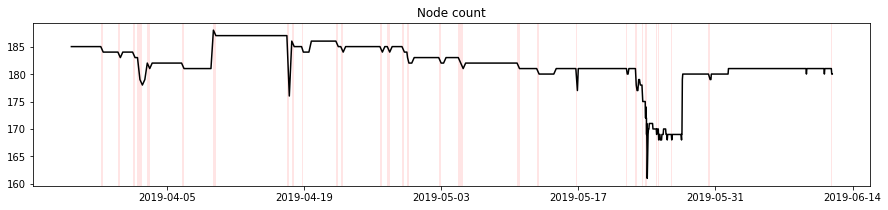

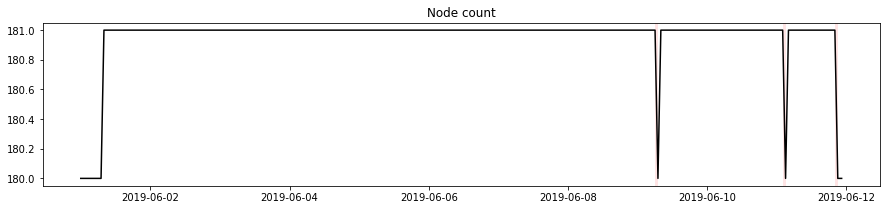

In [33]:
def plot_range(df):
    fig,ax = plt.subplots(figsize=(15,3))
    ax.plot_date(df.date,df.nhosts,fmt="o-",ms=0,lw=1.5,color="k");
    decreasing_idxs = df.date[df.nhosts.diff()<0].index.values
    for didx in decreasing_idxs:
        ax.axvspan(df.date[didx-1],df.date[didx],alpha=0.1,color="r",lw=0)
    ax.set_title("Node count");
plot_range(df_hadoop)
# Zoom in more
plot_range(df_hadoop[(df_hadoop.date.dt.month >= 6) & (df_hadoop.date.dt.day >= 1)])

Plot the red bad bands and overlay various users to see if there's an obvious correlation.
The y-axis is the fraction of CPU used (normalized to number of requested CPUs). I.e., 200% means you requested 1 core and used 2 cores' worth of CPU cycles (no-no).

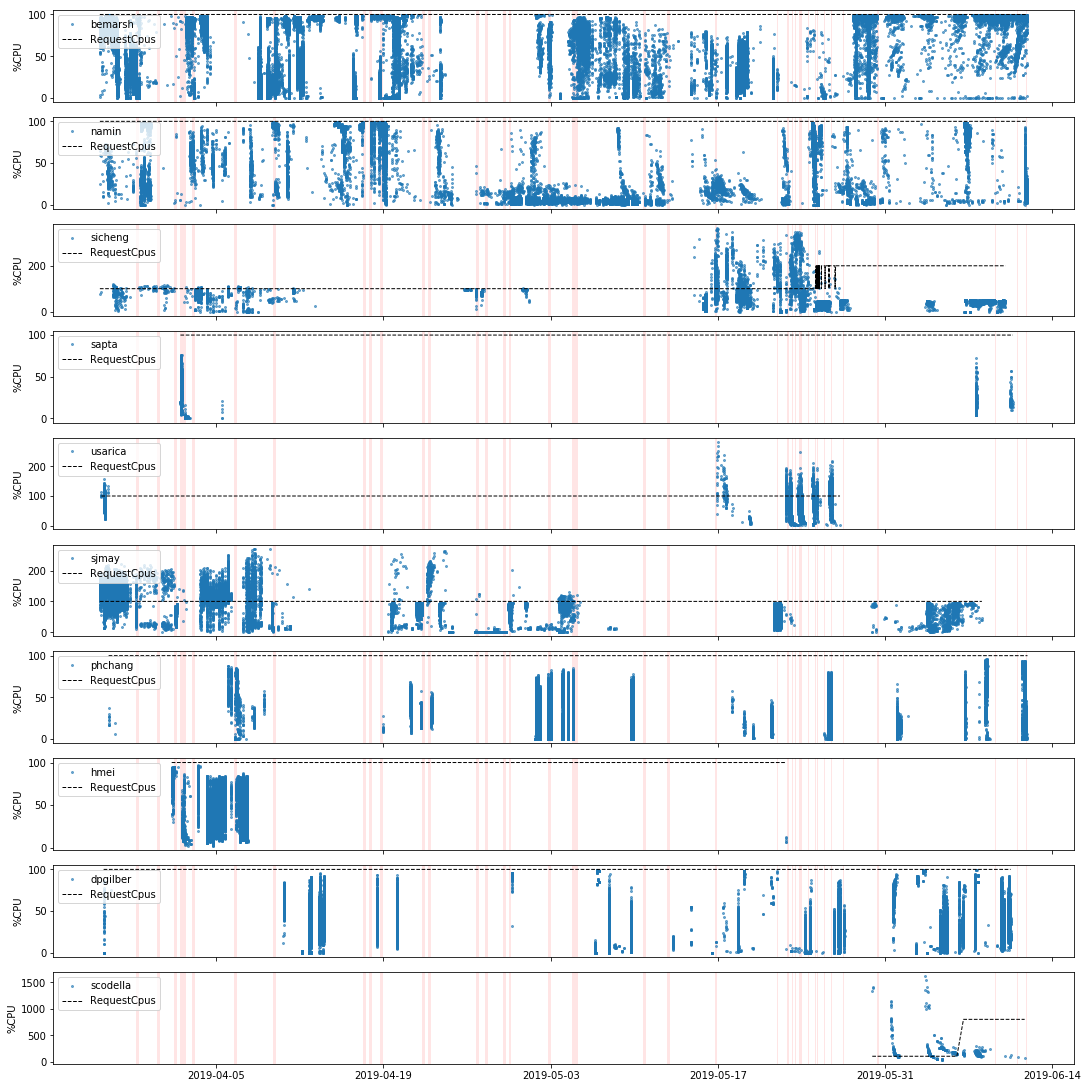

In [14]:
def plot_users_cpu():
    users = ["bemarsh","namin","sicheng","sapta","usarica","sjmay","phchang","hmei","dpgilber","scodella"]
    fig,axs = plt.subplots(len(users),1,figsize=(15,15),sharex=True,constrained_layout=True)
    for user,ax in zip(
        users,
        axs.flat,
    ):
        decreasing_idxs = df_hadoop.date[df_hadoop.nhosts.diff()<0].index.values
        for didx in decreasing_idxs:
            ax.axvspan(df_hadoop.date[didx-1],df_hadoop.date[didx],alpha=0.1,color="r",lw=0)
        df = df_condor[(df_condor.user==user) & (df_condor.CompletionDate >= df_hadoop.date.min())]
        df = df.sort_values("CompletionDate")
        ax.plot_date(df.CompletionDate,df.fcpu*100,fmt="o",ms=2,label=user,alpha=0.6);
        ax.plot_date(df.CompletionDate,df.RequestCpus*100.,fmt="--",ms=0,lw=1.0,color="k",alpha=1.0);
#         ax.plot_date([df_hadoop.date.min(),df_hadoop.date.max()],[100,100],fmt="--",color="k")
        ax.set_ylabel("%CPU")
        ax.legend(loc="upper left")
plot_users_cpu()

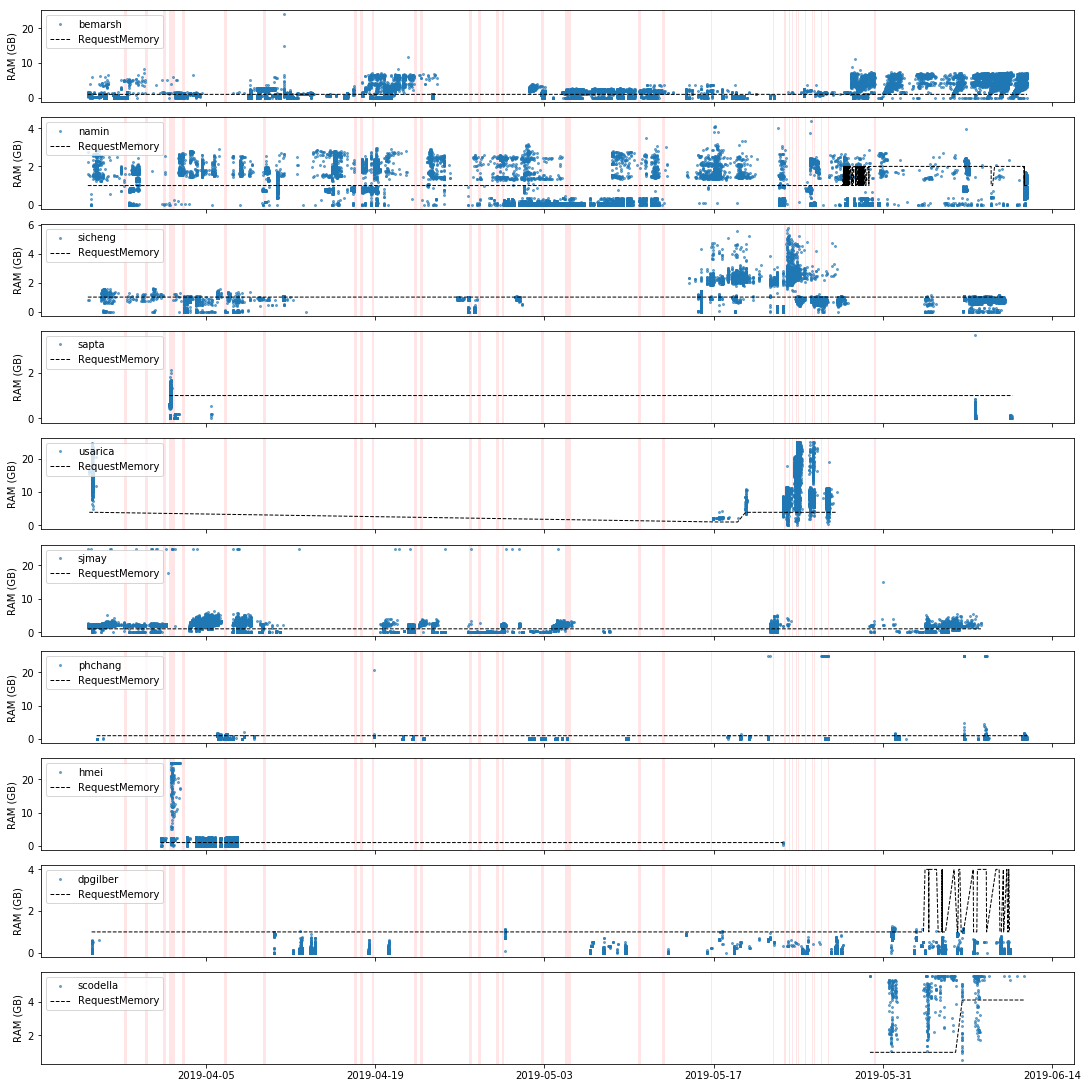

In [15]:
def plot_users_ram():
    users = ["bemarsh","namin","sicheng","sapta","usarica","sjmay","phchang","hmei","dpgilber","scodella"]
    fig,axs = plt.subplots(len(users),1,figsize=(15,15),sharex=True,constrained_layout=True)
    for user,ax in zip(
        users,
        axs.flat,
    ):
        decreasing_idxs = df_hadoop.date[df_hadoop.nhosts.diff()<0].index.values
        for didx in decreasing_idxs:
            ax.axvspan(df_hadoop.date[didx-1],df_hadoop.date[didx],alpha=0.1,color="r",lw=0)
        df = df_condor[(df_condor.user==user) & (df_condor.CompletionDate >= df_hadoop.date.min())]
        df = df.sort_values("CompletionDate")
        memgb = np.clip(df.memGB,None,25.)
        ax.plot_date(df.CompletionDate,memgb,fmt="o",ms=2,label=user,alpha=0.6);
        ax.plot_date(df.CompletionDate,df.RequestMemory/1024,fmt="--",ms=0,lw=1.0,color="k",alpha=1.0);
#         ax.plot_date([df_hadoop.date.min(),df_hadoop.date.max()],[100,100],fmt="--",color="k")
        ax.set_ylabel("RAM (GB)")
#         ax.set_yscale("log")
        ax.legend(loc="upper left")
plot_users_ram()

In [16]:
# Find intervals where we lost hosts wrt previous log
badrows = df_hadoop.query("nhosts_lost>=1")
badrows

,index,nodes,hosts_gained,hosts_lost,nhosts_gained,nhosts_lost,nhosts,date,prev_date,prev_interval
14,538,185.0,{},{cabinet-0-0-17},0,1,184,2019-03-29 12:01:01-07:00,2019-03-29 06:01:01-07:00,06:00:00
21,258,184.0,{},{cabinet-7-7-0},0,1,183,2019-03-31 06:01:01-07:00,2019-03-31 00:01:01-07:00,06:00:00
27,545,184.0,{},{cabinet-4-4-25},0,1,183,2019-04-01 18:01:01-07:00,2019-04-01 12:01:01-07:00,06:00:00
29,424,180.0,{},"{cabinet-7-7-28, cabinet-7-7-9, cabinet-6-6-5,...",0,4,179,2019-04-02 06:01:01-07:00,2019-04-02 00:01:01-07:00,06:00:00
30,747,179.0,{},{sdsc-44},0,1,178,2019-04-02 12:01:01-07:00,2019-04-02 06:01:01-07:00,06:00:00
33,283,182.0,{},{cabinet-7-7-28},0,1,181,2019-04-03 06:01:01-07:00,2019-04-03 00:01:01-07:00,06:00:00
47,19,182.0,{},{cabinet-2-2-15},0,1,181,2019-04-06 18:01:01-07:00,2019-04-06 12:01:01-07:00,06:00:00
60,593,188.0,{},{cabinet-7-7-26},0,1,187,2019-04-10 00:01:01-07:00,2019-04-09 18:01:01-07:00,06:00:00
90,237,177.0,{cabinet-2-2-25},"{cabinet-7-7-33, cabinet-8-8-2, cabinet-4-4-30...",1,12,176,2019-04-17 12:01:02-07:00,2019-04-17 06:01:01-07:00,06:00:01
92,733,186.0,{},{cabinet-7-7-28},0,1,185,2019-04-18 00:01:01-07:00,2019-04-17 18:01:01-07:00,06:00:00


In [17]:
# For each "badrow", get all the condor jobs that overlapped with that 6 hour interval
# Concatenate them into a "bad" DF
# Well, they are actually *candidate* "bad" jobs
ndf = []
# FIXME FIXME currently we're not restricting to the right hosts. but that's to get more statistics and be less biased
for idx,row in badrows.iterrows():
    hosts = list(row.hosts_lost)
    df_bad = df_condor[
        # Get df of condor jobs running on that host
        (df_condor.host.isin(hosts)) &
        # EXCLUDE jobs that (completed before the hadoop node check interval) OR (started after the hadoop node check interval)
        ~((df_condor.CompletionDate < row["prev_date"]) | (df_condor.JobStartDate > row["date"]))
    ]
    ndf.append(df_bad)
df_bad = pd.concat(ndf)
df_bad

,index,BytesRecvd,BytesSent,ClusterId,CompletionDate,CumulativeRemoteUserCpu,CumulativeSlotTime,DiskUsage_RAW,ExecutableSize_RAW,ExitCode,ExitStatus,JobRunCount,JobStartDate,JobStatus,LastJobStatus,NumJobStarts,Owner,ProcId,RemoteUserCpu,RemoteWallClockTime,RequestCpus,RequestDisk,RequestMemory,ResidentSetSize_RAW,TransferInputSizeMB,site,slot,host,user,fcpu,diskGB,memGB
62247,1,4.597347e+09,1048630.0,9815171,2019-04-02 06:00:24-07:00,2501.0,14872,11941958,2,0.0,0,1.0,2019-04-02 01:52:32-07:00,4,2,1,hmei,0,2501,14872,1,5242880,1024,10385056.0,4384,UCSD,slot1_3@cabinet-6-6-5.t2.ucsd.edu,cabinet-6-6-5,hmei,0.168168,11.941958,10.385056
62248,2,4.597347e+09,1048630.0,9815176,2019-04-02 05:59:07-07:00,2306.0,14795,11941958,2,0.0,0,1.0,2019-04-02 01:52:32-07:00,4,2,1,hmei,0,2306,14795,1,5242880,1024,10275796.0,4384,UCSD,slot1_3@cabinet-6-6-5.t2.ucsd.edu,cabinet-6-6-5,hmei,0.155863,11.941958,10.275796
62478,232,4.597347e+09,1009273.0,9815386,2019-04-02 03:11:25-07:00,1129.0,4188,11941950,2,0.0,0,1.0,2019-04-02 02:01:37-07:00,4,2,1,hmei,0,1129,4188,1,5242880,1024,1853516.0,4384,UCSD,slot1_2@cabinet-6-6-5.t2.ucsd.edu,cabinet-6-6-5,hmei,0.269580,11.941950,1.853516
62599,353,5.112840e+07,2162160.0,9815019,2019-04-02 02:26:44-07:00,1015.0,2525,4348095,9,0.0,0,1.0,2019-04-02 01:44:39-07:00,4,2,1,sapta,9,1015,2525,1,5242880,1024,905984.0,48,UCSD,slot1_2@cabinet-6-6-5.t2.ucsd.edu,cabinet-6-6-5,sapta,0.401980,4.348095,0.905984
62607,361,5.112840e+07,3089376.0,9815016,2019-04-02 02:24:41-07:00,1031.0,2529,3838156,9,0.0,0,1.0,2019-04-02 01:42:32-07:00,4,2,1,sapta,22,1031,2529,1,5242880,1024,878352.0,48,UCSD,slot1_2@cabinet-6-6-5.t2.ucsd.edu,cabinet-6-6-5,sapta,0.407671,3.838156,0.878352
62702,456,5.112840e+07,2213962.0,9815018,2019-04-02 02:15:53-07:00,844.0,1881,3388453,9,0.0,0,1.0,2019-04-02 01:44:32-07:00,4,2,1,sapta,3,844,1881,1,5242880,1024,674080.0,48,UCSD,slot1_3@cabinet-7-7-4.t2.ucsd.edu,cabinet-7-7-4,sapta,0.448698,3.388453,0.674080
62739,493,5.112840e+07,2757735.0,9815016,2019-04-02 02:13:04-07:00,1072.0,1832,3762453,9,0.0,0,1.0,2019-04-02 01:42:32-07:00,4,2,1,sapta,16,1072,1832,1,5242880,1024,675444.0,48,UCSD,slot1_3@cabinet-7-7-4.t2.ucsd.edu,cabinet-7-7-4,sapta,0.585153,3.762453,0.675444
62806,560,5.112840e+07,972541.0,9815017,2019-04-02 02:07:40-07:00,144.0,1423,317110,9,0.0,0,1.0,2019-04-02 01:43:57-07:00,4,2,1,sapta,61,144,1423,1,5242880,1024,571516.0,48,UCSD,slot1_2@cabinet-6-6-5.t2.ucsd.edu,cabinet-6-6-5,sapta,0.101195,0.317110,0.571516
62807,561,5.112840e+07,936454.0,9815017,2019-04-02 02:07:31-07:00,142.0,1414,316163,9,0.0,0,1.0,2019-04-02 01:43:57-07:00,4,2,1,sapta,59,142,1414,1,5242880,1024,562000.0,48,UCSD,slot1_2@cabinet-6-6-5.t2.ucsd.edu,cabinet-6-6-5,sapta,0.100424,0.316163,0.562000
62810,564,5.112840e+07,845194.0,9815017,2019-04-02 02:06:49-07:00,138.0,1401,316117,9,0.0,0,1.0,2019-04-02 01:43:28-07:00,4,2,1,sapta,19,138,1401,1,5242880,1024,572396.0,48,UCSD,slot1_2@cabinet-6-6-5.t2.ucsd.edu,cabinet-6-6-5,sapta,0.098501,0.316117,0.572396


**Are the above bad jobs too resource intensive?**


Avg cpu fraction for all condor jobs: 0.46
Avg cpu fraction for bad condor jobs: 0.38

Avg disk usage for all condor jobs: 0.65GB
Avg disk usage for bad condor jobs: 0.85GB

Avg memory usage for all condor jobs: 0.96GB
Avg memory usage for bad condor jobs: 3.94GB



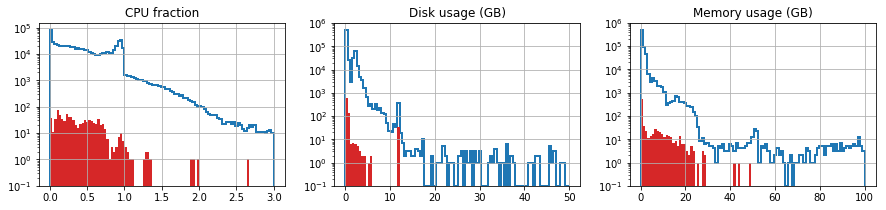

In [18]:
print("Avg cpu fraction for all condor jobs: {:.2f}".format(df_condor["fcpu"].mean()))
print("Avg cpu fraction for bad condor jobs: {:.2f}".format(df_bad["fcpu"].mean()))
print("")
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,3))
df_condor["fcpu"].hist(ax=ax1,bins=np.linspace(0,3,100),log=True,histtype="step",lw=2)
df_bad["fcpu"].hist(ax=ax1,bins=np.linspace(0,3,100),log=True,color="C3")
ax1.set_title("CPU fraction");

print("Avg disk usage for all condor jobs: {:.2f}GB".format(df_condor["diskGB"].mean()))
print("Avg disk usage for bad condor jobs: {:.2f}GB".format(df_bad["diskGB"].mean()))
print("")
df_condor["diskGB"].hist(ax=ax2,bins=np.linspace(0,50,100),log=True,histtype="step",lw=2)
df_bad["diskGB"].hist(ax=ax2,bins=np.linspace(0,50,100),log=True,color="C3")
ax2.set_title("Disk usage (GB)");

print("Avg memory usage for all condor jobs: {:.2f}GB".format(df_condor["memGB"].mean()))
print("Avg memory usage for bad condor jobs: {:.2f}GB".format(df_bad["memGB"].mean()))
print("")
df_condor["memGB"].hist(ax=ax3,bins=np.linspace(0,100,100),log=True,histtype="step",lw=2)
df_bad["memGB"].hist(ax=ax3,bins=np.linspace(0,100,100),log=True,color="C3")
ax3.set_title("Memory usage (GB)");

Apparently the memory usage is double the average.

**Also, what's going on in general with condor jobs that have >15GB memory usage?! Memory leaks?**

Take high memory usage jobs and separate by username

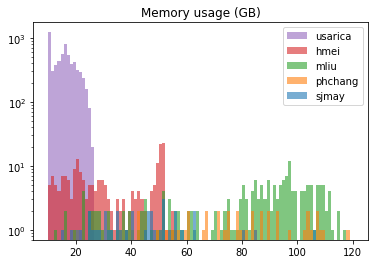

In [19]:
# Select high memory usage jobs and group by the user
big = df_condor[df_condor["memGB"]>10]
# big = df_condor[recent][df_condor[recent]["memGB"]>15]
grouped = big.groupby("user")
# Get the size of each group and only plot users that have at least 10 entries in the subsequent histogram
x = grouped.aggregate("size")
users = x[x>10.].sort_values().index.values
# For each of the users, get an array of the memory usage
vals = [grouped.get_group(user)["memGB"].values for user in users]
fig,ax = plt.subplots()
_ = ax.hist(vals,stacked=False,bins=np.linspace(10.,120.,100),label=users,histtype="stepfilled",alpha=0.6)
ax.set_yscale("log")
ax.legend()
ax.set_title("Memory usage (GB)");

**And what about jobs with a CPU fraction > 1?**

Well, for some wiggle room, only check CPU fraction > 120%

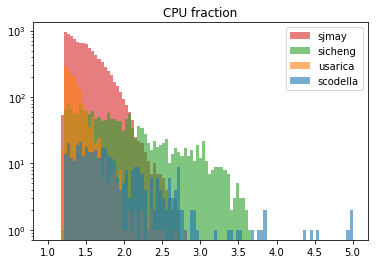

In [20]:
big = df_condor[df_condor["fcpu"]>1.2]
# big = df_condor[recent][df_condor[recent]["fcpu"]>1.2]
grouped = big.groupby("user")
x = grouped.aggregate("size")
users = x[x>10.].sort_values().index.values
vals = [grouped.get_group(user)["fcpu"].values for user in users]
fig,ax = plt.subplots()
_ = ax.hist(vals,stacked=False,bins=np.linspace(1.0,5,100),label=users,histtype="stepfilled",alpha=0.6)
ax.set_yscale("log")
ax.legend()
ax.set_title("CPU fraction");

**And jobs that use >15GB of disk?**
I suspect it's the rare foot-shooting where you write a root tree without clearing a vector branch every TTree::Fill()

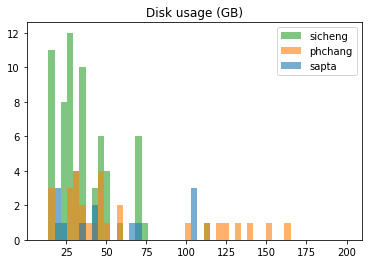

In [21]:
# Select high memory usage jobs and group by the user
big = df_condor[df_condor["diskGB"]>15]
grouped = big.groupby("user")
# Get the size of each group and only plot users that have at least 10 entries in the subsequent histogram
x = grouped.aggregate("size")
users = x[x>10.].sort_values().index.values
# For each of the users, get an array of the memory usage
vals = [grouped.get_group(user)["diskGB"].values for user in users]
fig,ax = plt.subplots()
_ = ax.hist(vals,stacked=False,bins=np.linspace(10.,200.,50),label=users,histtype="stepfilled",alpha=0.6)
# ax.set_yscale("log")
ax.legend()
ax.set_title("Disk usage (GB)");

**Back to the candidate bad jobs. Who are they?**

No clear culprit, and if you submit more condor jobs, you're more likely to show up in the list by chance.

In [22]:
df_bad.groupby("user").size()

user
bemarsh      32
dpgilber      3
hmei         33
jguiang     262
namin        21
phchang      41
sapta       105
sicheng     103
sjmay        37
usarica     184
dtype: int64

In [23]:
fusers_bad = (df_bad.groupby("user").size()/len(df_bad))
fusers_all = (df_condor.groupby("user").size()/len(df_condor))
# Relative ratio of users in bad set wrt full set
(fusers_bad/fusers_all).dropna().sort_values(ascending=False)

user
sapta       14.230239
usarica      9.914631
sicheng      5.504922
jguiang      4.873473
hmei         0.724316
phchang      0.630908
sjmay        0.415057
namin        0.390669
bemarsh      0.138263
dpgilber     0.026156
dtype: float64

**Actually, something I should have done at the beginning**
is check to see if certain hostnames are more prone to dropping hadoop nodes

(lost nodes might just be governed by bad hardware and not 100% strenuous user activity)

In [24]:
# Get 1D list of lost node hostnames
hosts = pd.Series(df_hadoop["hosts_lost"].map(list).values.sum())
print(hosts)

0     cabinet-0-0-17
1      cabinet-7-7-0
2     cabinet-4-4-25
3     cabinet-7-7-28
4      cabinet-7-7-9
5      cabinet-6-6-5
6      cabinet-7-7-4
7            sdsc-44
8     cabinet-7-7-28
9     cabinet-2-2-15
10    cabinet-7-7-26
11    cabinet-7-7-33
12     cabinet-8-8-2
13    cabinet-4-4-30
14    cabinet-7-7-28
15    cabinet-0-0-23
16    cabinet-4-4-31
17    cabinet-4-4-28
18    cabinet-4-4-29
19    cabinet-0-0-28
20    cabinet-7-7-23
21    cabinet-7-7-31
22    cabinet-7-7-25
23    cabinet-7-7-28
24    cabinet-4-4-29
25           sdsc-16
26     cabinet-7-7-5
27     cabinet-6-6-3
28    cabinet-7-7-22
29     cabinet-7-7-2
           ...      
69    cabinet-0-0-34
70     cabinet-0-0-4
71            sdsc-3
72           sdsc-30
73    cabinet-0-0-13
74     cabinet-2-2-4
75    cabinet-0-0-18
76    cabinet-2-2-16
77    cabinet-0-0-15
78     cabinet-0-0-1
79    cabinet-0-0-22
80    cabinet-0-0-24
81    cabinet-0-0-34
82    cabinet-0-0-28
83    cabinet-1-1-13
84    cabinet-8-8-12
85    cabinet

Maybe the first two numbers give a physical location? Rack/whatever? 
So I'll ignore the 3rd for histogramming purposes. Also ignore the lonely SDSC nodes.

In [25]:
# Pandas vectorized string operations are super neat
badbigcabinet = hosts[hosts.str.contains("cabinet")].str.rsplit("-",1).str[0]
# Fractions of "big cabinet" nodes (cabinet nodes grouped by first 2 numbers)
(badbigcabinet.value_counts()/len(badbigcabinet)).round(3)

cabinet-7-7      0.325
cabinet-0-0      0.253
cabinet-2-2      0.217
cabinet-4-4      0.096
cabinet-6-6      0.036
cabinet-8-8      0.036
cabinet-1-1      0.024
cabinet-11-11    0.012
dtype: float64

**Hmm. cabinet-7-7 is pretty popular.**

What about the distribution of nodes for all condor jobs?

In [26]:
allbigcabinet = df_condor.host[df_condor.host.str.contains("cabinet")].str.rsplit("-",1).str[0]
(allbigcabinet.value_counts()/len(allbigcabinet)).round(3)

cabinet-0-0      0.257
cabinet-5-5      0.220
cabinet-4-4      0.179
cabinet-11-11    0.093
cabinet-7-7      0.083
cabinet-1-1      0.058
cabinet-2-2      0.043
cabinet-8-8      0.040
cabinet-6-6      0.019
cabinet-3-3      0.007
Name: host, dtype: float64

**cabinet-7-7 is not so popular there.**

Taking the ratio, we see that 7-7 and 2-2 are 4-5x overrepresented in the bad set.

In [27]:
((badbigcabinet.value_counts()/len(badbigcabinet))/(allbigcabinet.value_counts()/len(allbigcabinet))).round(3).dropna()

cabinet-0-0      0.984
cabinet-1-1      0.413
cabinet-11-11    0.130
cabinet-2-2      4.986
cabinet-4-4      0.538
cabinet-6-6      1.901
cabinet-7-7      3.925
cabinet-8-8      0.897
dtype: float64

Typically how long are the nodes "out"? Are there bad jobs that knock them out for several hours, or do they stay out for days? 

**Note**: there are a just a handful of instances where we don't get clean pairs to compute "in"-"out" time intervals. Most of them are cases where we lost a hostname and never recovered it.

In [28]:
# Super convoluted, but basically we go through the hadoop dataframe (each row has a single observation
# of which cabinet/sdsc nodes are "in", as well as the list of new nodes "in" since the last 6 hour interval,
# and the list of nodes "out")

# We can find consecutive pairs of out-in instances (i.e., lost hostname foo, then got it back 12 hrs later)
# Store the hostname and the time to recover the hostname as rows in `recoveryinfo`

times = {}
for idx,row in df_hadoop.iterrows():
    if not row.hosts_lost and not row.hosts_gained: continue
    ts_now = row.date
    ts_prev = row.prev_date
    for h in row.hosts_lost:
        if h not in times: times[h] = []
        times[h].append([ts_now,-1])
    for h in row.hosts_gained:
        if h not in times: times[h] = []
        times[h].append([ts_now,1])
recoveryinfo = []
neverrecovered = []
for k,v in times.items():
    def diffs(x):
        # pair of [ts_now, +-1 (delta nodes)]
        (t0now,dn0),(t1now,dn1) = x
        dt = t1now.timestamp()-t0now.timestamp()
        # initially lost, then gained
        dn = 1 if (dn0==-1 and dn1==1) else -1
        return [dt,dn]
    if len(v)>=2:
        ts = times[k]
        pairs = zip(ts[:-1],ts[1:])
        recoveryhours = [round(x[0]/3600.) for x in map(diffs,pairs) if x[1] == 1]
        for rh in recoveryhours:
            recoveryinfo.append([k,rh])
    elif len(v)==1:
        if v[0][1] == -1:
            neverrecovered.append([k, v[0][0]])



Print out the hosts that were lost (and never recovered)

In [29]:
pd.DataFrame(neverrecovered,columns=["host","date"]).sort_values("date").reset_index()

,index,host,date


Now consider the recovery time of hosts/nodes

In [30]:
df = pd.DataFrame(recoveryinfo,columns=["host","hours"])
df.head()

,host,hours
0,cabinet-0-0-1,3.0
1,cabinet-0-0-23,6.0
2,cabinet-0-0-22,2.0
3,cabinet-0-0-22,86.0
4,cabinet-0-0-24,1.0


Most recoveries happen within the 6 hour logging interval

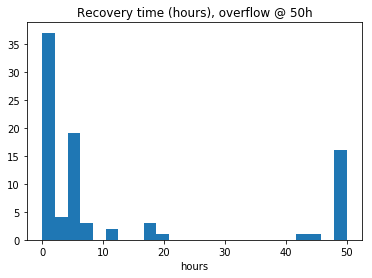

In [31]:
plt.hist(np.clip(df.hours,0,50),bins=np.linspace(0,50,25));
plt.xlabel("hours")
plt.title("Recovery time (hours), overflow @ 50h");

Now separate the previous inclusive histogram based on cabinet-X-X-Y (but sum over Y).
Jitter the points so that overlap doesn't hide the density (2D hists are second-class citizens
in matplotlib and I'm too lazy)

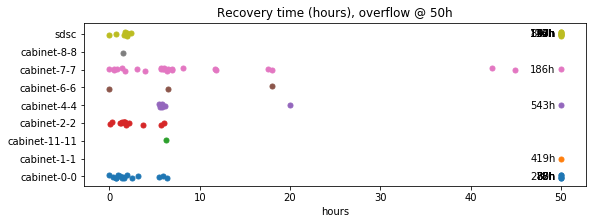

In [32]:
df["bighost"] = df.host.str.rsplit("-",1).str[0].astype("category")
grouped = df.groupby("bighost")
fig,ax = plt.subplots(figsize=(9,3))
for code,host in enumerate(df.bighost.cat.categories):
    hours = grouped.get_group(host)["hours"].values
    for hour in hours[hours>=50.]:
        ax.text(49.4,code,str(int(hour))+"h",va="center",ha="right")
    xfuzz = (2*np.random.random(len(hours))-1)*0.5
    yfuzz = (2*np.random.random(len(hours))-1)*0.1
    ax.scatter(np.clip(hours+xfuzz,0,50),np.array([code for _ in hours])+yfuzz,s=25)
plt.yticks(*zip(*enumerate(df.bighost.cat.categories)));
plt.xlabel("hours")
plt.title("Recovery time (hours), overflow @ 50h");

In [48]:
df_condor.columns

Index([                  u'index',              u'BytesRecvd',
                     u'BytesSent',               u'ClusterId',
                u'CompletionDate', u'CumulativeRemoteUserCpu',
            u'CumulativeSlotTime',           u'DiskUsage_RAW',
            u'ExecutableSize_RAW',                u'ExitCode',
                    u'ExitStatus',             u'JobRunCount',
                  u'JobStartDate',               u'JobStatus',
                 u'LastJobStatus',            u'NumJobStarts',
                         u'Owner',                  u'ProcId',
                 u'RemoteUserCpu',     u'RemoteWallClockTime',
                   u'RequestCpus',             u'RequestDisk',
                 u'RequestMemory',     u'ResidentSetSize_RAW',
           u'TransferInputSizeMB',                    u'site',
                          u'slot',                    u'host',
                          u'user',                    u'fcpu',
                        u'diskGB',                   u'

In [36]:
dfnl = pd.read_pickle("nodelogs.pkl")

dfnl["date"] = pd.to_datetime(dfnl["date"]).dt.tz_localize("UTC").dt.tz_convert("US/Pacific")

In [37]:
ndf = []
for idx,row in tqdm(dfnl.iterrows()):
    node = str(row.node)
    df_bad = df_condor[
        (df_condor.host == node) &
        # EXCLUDE jobs that (completed before the hadoop node check interval) OR (started after the hadoop node check interval)
        ~((df_condor.CompletionDate < row["date"]) | (df_condor.JobStartDate > row["date"]))
    ]
    ndf.append(df_bad)
df_bad = pd.concat(ndf)
df_bad

126it [00:07, 16.22it/s]


,index,BytesRecvd,BytesSent,ClusterId,CompletionDate,CumulativeRemoteUserCpu,CumulativeSlotTime,DiskUsage_RAW,ExecutableSize_RAW,ExitCode,ExitStatus,JobRunCount,JobStartDate,JobStatus,LastJobStatus,NumJobStarts,Owner,ProcId,RemoteUserCpu,RemoteWallClockTime,RequestCpus,RequestDisk,RequestMemory,ResidentSetSize_RAW,TransferInputSizeMB,site,slot,host,user,fcpu,diskGB,memGB
124468,899,148348160.0,51079.0,558621,2019-05-22 19:06:28-07:00,20149,48072,3418857,11,0.0,0,4.0,2019-05-22 05:44:22-07:00,4,2,4,namin,198,20070,48072,1,5242880,1024,1502620.0,35,UCSD,slot1_6@cabinet-11-11-13.t2.ucsd.edu,cabinet-11-11-13,namin,0.417499,3.418857,1.502620
322086,408,11434186.0,4299906.0,10006967,2019-05-23 03:57:22-07:00,149611,73392,1024076,10,0.0,0,1.0,2019-05-22 07:34:10-07:00,4,2,1,sicheng,2,149611,73392,1,5242880,1024,2649016.0,10,UCSD,slot1_5@cabinet-11-11-13.t2.ucsd.edu,cabinet-11-11-13,sicheng,2.038519,1.024076,2.649016
322462,784,11434186.0,4384912.0,10006418,2019-05-23 03:13:55-07:00,150776,70785,1045922,10,0.0,0,1.0,2019-05-22 07:34:10-07:00,4,2,1,sicheng,162,150776,70785,1,5242880,1024,2641148.0,10,UCSD,slot1_4@cabinet-11-11-13.t2.ucsd.edu,cabinet-11-11-13,sicheng,2.130056,1.045922,2.641148
322820,1142,11434186.0,4162645.0,10006418,2019-05-23 02:49:09-07:00,144473,69299,1008071,10,0.0,0,1.0,2019-05-22 07:34:10-07:00,4,2,1,sicheng,161,144473,69299,1,5242880,1024,2527412.0,10,UCSD,slot1_5@cabinet-11-11-13.t2.ucsd.edu,cabinet-11-11-13,sicheng,2.084778,1.008071,2.527412
323100,1422,11434186.0,4169524.0,10006967,2019-05-23 02:37:59-07:00,143845,68628,1005796,10,0.0,0,1.0,2019-05-22 07:34:11-07:00,4,2,1,sicheng,3,143845,68628,1,5242880,1024,2871988.0,10,UCSD,slot1_4@cabinet-11-11-13.t2.ucsd.edu,cabinet-11-11-13,sicheng,2.096010,1.005796,2.871988
324446,2768,11434186.0,3931265.0,10006967,2019-05-23 02:00:24-07:00,139630,66371,961413,10,0.0,0,1.0,2019-05-22 07:34:13-07:00,4,2,1,sicheng,11,139630,66371,1,5242880,1024,2636584.0,10,UCSD,slot1_5@cabinet-11-11-13.t2.ucsd.edu,cabinet-11-11-13,sicheng,2.103780,0.961413,2.636584
322150,472,255390672.0,23237708.0,10007593,2019-05-23 03:45:58-07:00,25224,63439,1887795,2,0.0,0,1.0,2019-05-22 10:08:39-07:00,4,2,1,sjmay,0,25224,63439,1,5242880,1024,2493300.0,243,UCSD,slot1_3@cabinet-0-0-23.t2.ucsd.edu,cabinet-0-0-23,sjmay,0.397610,1.887795,2.493300
322333,655,22868372.0,4063814.0,9995988,2019-05-23 03:24:41-07:00,174429,81466,975749,10,0.0,0,2.0,2019-05-22 04:25:07-07:00,4,2,2,sicheng,243,162338,81466,1,5242880,1024,2294648.0,10,UCSD,slot1_2@cabinet-7-7-22.t2.ucsd.edu,cabinet-7-7-22,sicheng,1.992709,0.975749,2.294648
793814,515,11434186.0,1531601.0,10006418,2019-05-22 17:53:49-07:00,55989,37265,457339,10,1.0,0,1.0,2019-05-22 07:32:44-07:00,4,2,1,sicheng,46,55989,37265,1,5242880,1024,2639712.0,10,UCSD,slot1_1@cabinet-0-0-29.t2.ucsd.edu,cabinet-0-0-29,sicheng,1.502455,0.457339,2.639712
44750,10,418401.0,3135335.0,9990893,2019-05-25 19:54:37-07:00,134432,647301,6161547,11,1.0,0,11.0,2019-05-17 13:53:05-07:00,4,2,9,bemarsh,73,23102,647301,1,5242880,1024,1535444.0,0,UCSD,slot1_5@sdsc-42.t2.ucsd.edu,sdsc-42,bemarsh,0.035690,6.161547,1.535444


In [38]:
df_good = df_condor[
    (~df_condor.ClusterId.isin(df_bad.ClusterId)) &
    (df_condor.CompletionDate > dfnl.date.min())
    ]

In [39]:
print df_bad.shape
print df_good.shape

(292, 32)
(74665, 32)


In [40]:
bad_users = df_bad.user.value_counts()/len(df_bad)
bad_users

sicheng     0.705479
usarica     0.208904
namin       0.034247
bemarsh     0.027397
dpgilber    0.010274
sjmay       0.006849
hmei        0.006849
Name: user, dtype: float64

In [41]:
good_users = df_good.user.value_counts()/len(df_good)
good_users

jguiang     0.325280
dpgilber    0.280975
usarica     0.162030
namin       0.074961
bsathian    0.074319
sicheng     0.038224
phchang     0.033550
mbryson     0.008531
bemarsh     0.002022
sjmay       0.000107
Name: user, dtype: float64

In [42]:
(bad_users/good_users).dropna().sort_values(ascending=False)

sjmay       63.925514
sicheng     18.456420
bemarsh     13.547129
usarica      1.289290
namin        0.456856
dpgilber     0.036565
Name: user, dtype: float64

In [65]:
df_condor.columns

Index([                  u'index',              u'BytesRecvd',
                     u'BytesSent',               u'ClusterId',
                u'CompletionDate', u'CumulativeRemoteUserCpu',
            u'CumulativeSlotTime',           u'DiskUsage_RAW',
            u'ExecutableSize_RAW',                u'ExitCode',
                    u'ExitStatus',             u'JobRunCount',
                  u'JobStartDate',               u'JobStatus',
                 u'LastJobStatus',            u'NumJobStarts',
                         u'Owner',                  u'ProcId',
                 u'RemoteUserCpu',     u'RemoteWallClockTime',
                   u'RequestCpus',             u'RequestDisk',
                 u'RequestMemory',     u'ResidentSetSize_RAW',
           u'TransferInputSizeMB',                    u'site',
                          u'slot',                    u'host',
                          u'user',                    u'fcpu',
                        u'diskGB',                   u'

In [32]:
df_condor[df_condor.site=="UCSD"]["ExitCode"].value_counts()

0.0      436984
2.0      170126
1.0       19127
255.0      6515
93.0        649
13.0        560
70.0         85
126.0        13
84.0         12
127.0         2
110.0         2
85.0          1
Name: ExitCode, dtype: int64

UCSD
MIT
Purdue
NotreDame
Vanderbilt
Colorado
Unknown


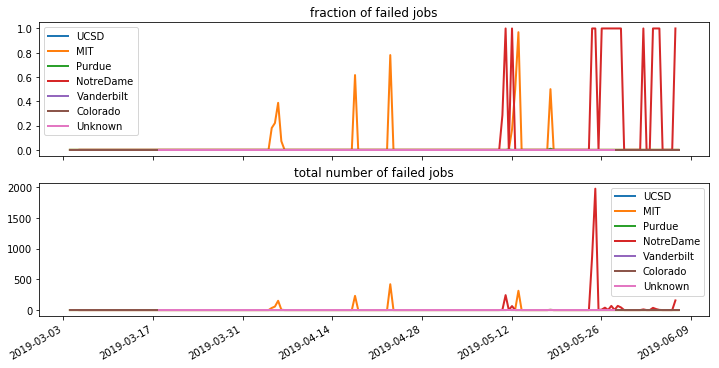

In [40]:
df_condor["site"] = df_condor["site"].astype("category")

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,6),sharex=True)
for x in df_condor.site.value_counts().sort_values(ascending=False)[:7].keys().values:
    print x
    gb = df_condor[df_condor["user"]=="namin"].groupby(["site"])
    df = gb.get_group(x)[["JobStartDate","ExitCode"]]
    df["good"] = df["ExitCode"]==0
#     df["bad"] = df["ExitCode"]==255
    df["bad"] = df["ExitCode"]>2
    df = df.set_index(df["JobStartDate"]).drop("ExitCode",axis=1)
    df = df.resample("12h").sum()
    df["fbad"] = (df["bad"]/(df["good"]+df["bad"])).fillna(0.)
#     ax.plot_date(df.index,df.fbad,label=x,ms=0,lw=2,ls="-")
    ax1.plot_date(df.index,df["fbad"],label=x,ms=0,lw=2,ls="-")
    ax2.plot_date(df.index,df["bad"],label=x,ms=0,lw=2,ls="-")
ax1.legend()
ax2.legend()
# ax1.set_yscale("log")
# ax2.set_yscale("log")
ax1.set_title("fraction of failed jobs")
ax2.set_title("total number of failed jobs")
fig.autofmt_xdate()


Index                      6756872
index                      6756872
BytesRecvd                 6756872
BytesSent                  6756872
ClusterId                  6756872
CompletionDate             6756872
CumulativeRemoteUserCpu    6756872
CumulativeSlotTime         6756872
DiskUsage_RAW              6756872
ExecutableSize_RAW         6756872
ExitCode                   6756872
ExitStatus                 6756872
JobRunCount                6756872
JobStartDate               6756872
JobStatus                  6756872
LastJobStatus              6756872
NumJobStarts               6756872
Owner                       845409
ProcId                     6756872
RemoteUserCpu              6756872
RemoteWallClockTime        6756872
RequestCpus                6756872
RequestDisk                6756872
RequestMemory              6756872
ResidentSetSize_RAW        6756872
TransferInputSizeMB        6756872
site                        845433
slot                       1902498
host                

In [ ]:
df_condor.columns
for cname in ["Owner","slot","user","host","site"]:
    df_condor[cname] = df_condor[cname].astype("category")
# df_condor.to_pickle("test.pkl.gz")

In [35]:
df_condor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 631551 entries, 0 to 2103749
Data columns (total 32 columns):
index                      631551 non-null int64
BytesRecvd                 631551 non-null float64
BytesSent                  631551 non-null float64
ClusterId                  631551 non-null int64
CompletionDate             631551 non-null datetime64[ns, US/Pacific]
CumulativeRemoteUserCpu    623475 non-null float64
CumulativeSlotTime         631551 non-null int64
DiskUsage_RAW              631551 non-null int64
ExecutableSize_RAW         631551 non-null int64
ExitCode                   629842 non-null float64
ExitStatus                 631551 non-null int64
JobRunCount                631551 non-null float64
JobStartDate               631551 non-null datetime64[ns, US/Pacific]
JobStatus                  631551 non-null int64
LastJobStatus              631551 non-null int64
NumJobStarts               631551 non-null int64
Owner                      631551 non-null object
Pr

In [41]:
df_condor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 631551 entries, 0 to 2103749
Data columns (total 29 columns):
index                      631551 non-null int64
ClusterId                  631551 non-null int64
CompletionDate             631551 non-null datetime64[ns, US/Pacific]
CumulativeRemoteUserCpu    623475 non-null float64
CumulativeSlotTime         631551 non-null int64
DiskUsage_RAW              631551 non-null int64
ExitCode                   629842 non-null category
ExitStatus                 631551 non-null category
JobRunCount                631551 non-null uint16
JobStartDate               631551 non-null datetime64[ns, US/Pacific]
JobStatus                  631551 non-null category
LastJobStatus              631551 non-null category
NumJobStarts               631551 non-null uint16
Owner                      631551 non-null category
ProcId                     631551 non-null int64
RemoteUserCpu              631551 non-null int64
RemoteWallClockTime        631551 non-null 